In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import random

## Let's be clear what is "DERIVATIVE" of one simple function with one input?

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

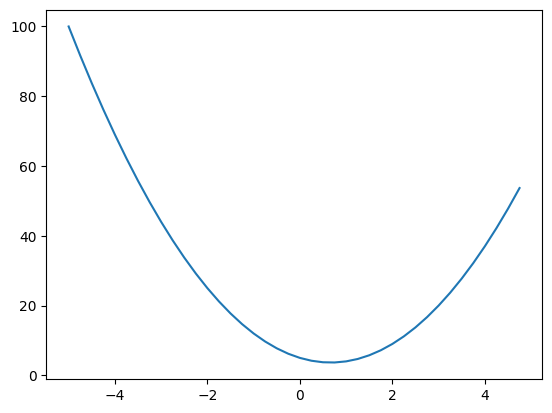

In [4]:
xs = np.arange(-5,5, 0.25) #from -5 t0 5 with step 0.5
ys = f(xs)
plt.plot(xs,ys)

In [5]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [6]:
#definition of derivative
h = 0.000001 #tent to zero by formula
x = 3 #try -3, 2/3
f(x)
(f(x + h) - f(x)) / h

14.000003002223593

In [7]:
#lets get more complex function
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [8]:
h = 0.0001

#inputs
a = 2
b = -3
c = 10

d1 = a*b + c #initial 
a += h #bumped a to a positive direction by a lil bit 
d2 = a*b + c #how its gonna effect 



print('d1', d1)
print('d2', d2)
print('actual slope', (d2-d1)/h)

d1 4
d2 3.999699999999999
actual slope -3.000000000010772


## Core "Value" object of Micrograd

In [19]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): #children to kinda relate them to one another!
        self.data = data
        self._children = set(_children) #children for understanding the created value is from what, e.g. d is from addition of a,b
        self._op = _op #from what operation 
        self.label = label #to create a label for the dat values
        self.grad = 0.0 #initial set to zero, meaning slight change in the variables does not impact the loss function
        self._backward = lambda: None #chain rule at each node empty by default bc of the some of the biases #for leaf node
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other) #a+1
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad #local der * global der (der of final w respect to that data)
            other.grad += 1.0 * out.grad #copied
        out._backward = _backward
        return out



    def __pow__(self, other):
        assert isinstance(other, (int,float)), "inly supporting int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad +=  other * (self.data **(other-1)) * out.grad 
            
        out._backward = _backward

        return out
        
    def __mul__(self, other, _op='*'):
        other = other if isinstance(other, Value) else Value(other) #aa*2
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad +=  other.data * out.grad #local der * global der (der of final w respect to that data)
            other.grad += self.data * out.grad # we wanna chain the out.grad into other.grad 
            
        out._backward = _backward

        return out

    def __rmul__(self, other): #2 * a == a * 2 (a.__mul__(2)):
        return self * other 


    def __truediv__(self, other): #self / other
        return self * other**-1

    def __neg__(self): #-self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')

        def _backward():
            self.grad +=  out.data * out.grad #deriv e*x is e*x that we already calculated inside the out 
        out._backward = _backward

        return out

    
    def tanh(self): #dont need atomic function of, up to us how complicated 
        x = self.data
        t = (math.exp(2*x)-1)/ (math.exp(2*x)+1)
        out = Value(t, (self, ),'tanh') #tuple is the children of this node 

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v) #mark as visied 
                for child in v._children:
                    build_topo(child)
                topo.append(v) #after all children are processed go and add yourself 
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [44]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self): #dont need atomic function of, up to us how complicated 
        x = self.data
        t = (math.exp(2*x)-1)/ (math.exp(2*x)+1)
        out = Value(t, (self, ),'tanh') #tuple is the children of this node 

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [10]:
a= Value(2)
b = Value(4)
a / b
a - b

Value(data=-2)

In [11]:
obj1 = Value(3)
a = Value(2, label= 'a')
b = Value(-3, label='b')
c = Value(10, label='c')
#a + b #internally a.__add__(b)
e=a*b; e.label = 'e'
d=e + c; d.label = 'd'
f = Value(-2, label='f')
L = d * f; L.label='L' #overal output

In [12]:
d._children

{Value(data=-6), Value(data=10)}

In [13]:
d._op

'+'

## Graphical visualization 

In [38]:
#visualualize in graph
#trace is building the graph
def trace(root):
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build_graph(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format= 'svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        #for any value in graph, create a rectangular ('record') for it 
        dot.node(name=str(id(n)), label="{%s | data %.3f | grad %.3f}" % (n.label, n.data, n.grad), shape='record') #label = {%s | data %.4f | grad%.4f}" % (n.label, n.data)
        if n._op:
            #if this value is a result of an +/* operation, create an op node for it 
            dot.node(str(id(n)) + n._op, label = n._op)
            #connect it to the corresponding node 
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot    

In [31]:
draw_dot(L)

NameError: name 'L' is not defined

we know how d impact L, and we know how c impact d(dd/dc) (plus sign d = e + c), now we wanna know how c impact L!
dd / dc=1
dd/ de = 1 (local derivative bc this have no clue of the whole network derivative L that we know!)
acheieved by Chain Rule
d = e + c 

WANT:
dL / dc = (dL/dd) * (dd/dc) second one is 1 bc of the plus sign so it sounds like it just passed it thro!

KNOW:
dL/dd
dd / dc
d = e + c



L = d * f
dl/dd = ? f

dL/dc


In [59]:
c.grad = -2
e.grad = -2


d.grad = -2
f.grad = 4

again for a , b

dL / de = -2
e = a * b

dL / da = (dL/de) * (de/da) = -2 * b = -2 * -3 = 6

In [72]:
a.grad = -2 * -3
b.grad = -2 * 2

## Manual backpro; simple expression; exp1

In [75]:
#what is the derivate of L with respect to L/ f to L
#in other word if we change f a lil bit, how does it affect the l 
def lol():
    h = 0.001
    a = Value(2, label= 'a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    #a + b #internally a.__add__(b)
    e=a*b; e.label = 'e'
    d=e + c; d.label = 'd'
    f = Value(-2, label='f')
    L = d * f; L.label='L' #overal output
    L1 = L.data

    a = Value(2, label= 'a') #2 +h change a w respect to a
    #a.data += h
    b = Value(-3, label='b')
    b.data += h
    c = Value(10, label='c')
    #a + b #internally a.__add__(b)
    e=a*b; e.label = 'e'
    #e.data += h
    d=e + c; d.label = 'd'
    f = Value(-2, label='f')
    L = d * f; L.label='L' #overal output
    L2  = L.data  #chsnge l W respect to L 

    print((L2 - L1)/h)

In [76]:
lol()

-3.9999999999995595


In [33]:
L.grad = 1.0

## Manual backpro; simple expression; exp2; a Neuron
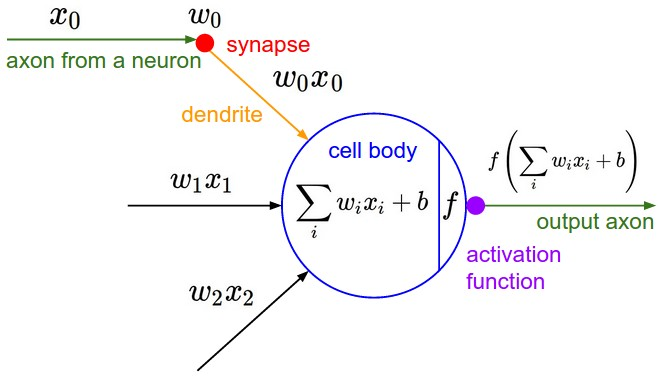

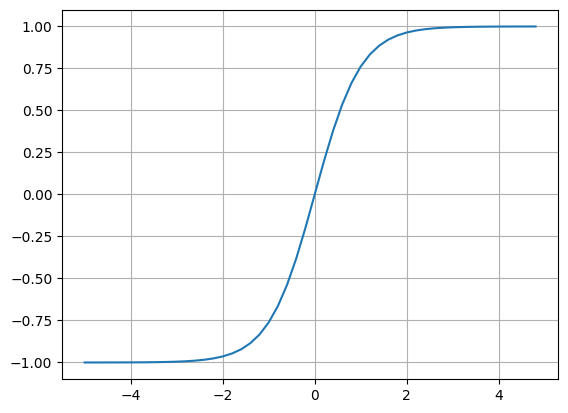

In [80]:
#bias innner triger happiness # f---> activation function kinda likea squating function 
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))) ; plt.grid()

In [17]:
#inputs x1,x2
x1 = Value(2, label='x1')
x2 = Value(0.0, label='x2')

#weights for inputs
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label ='b')
#according to model; x1*w1 + x2*w2 + b  ----> raw body without activation function 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'w1*x1 + w2*x2'
n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh(); o.label = 'o'
o.backward()

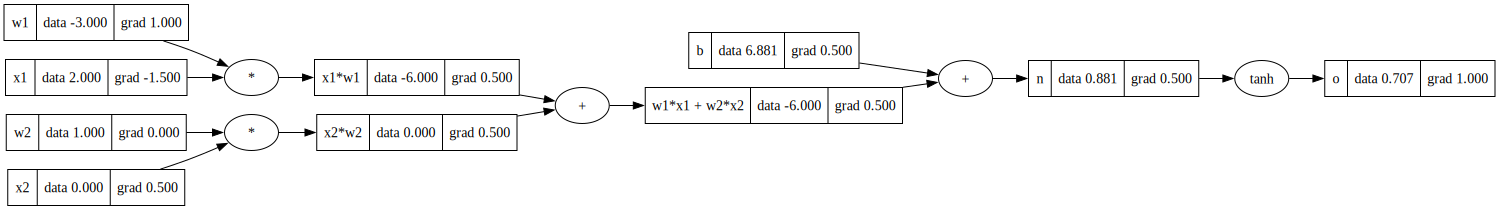

In [18]:
draw_dot(o)

In [207]:
#same but nistead of using tanh, we use exp 
#inputs x1,x2
x1 = Value(2, label='x1')
x2 = Value(0.0, label='x2')

#weights for inputs
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label ='b')
#according to model; x1*w1 + x2*w2 + b  ----> raw body without activation function 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'w1*x1 + w2*x2'
n = x1w1x2w2 + b; n.label = 'n' 
e = (2*n).exp(); #variable
o = (e-1) / (e+1)
o.label = 'o'
o.backward()

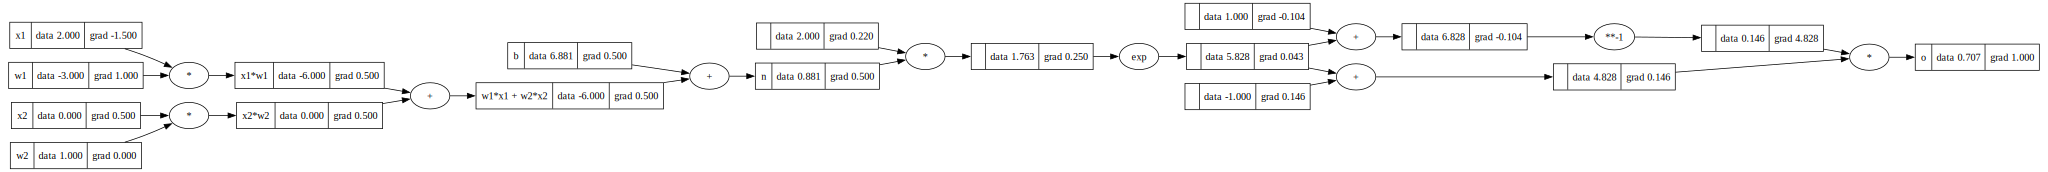

In [208]:
draw_dot(o)

In [176]:
#with the new topo backward
o.backward()

In [167]:
o.grad = 1 #deriative of o wres to o is 1
#local deriv of tanh so; o = tanh(n) ---> do/dn = 1- tanh**2 ---> i - o**2
o.data

0.7158008515293363

In [113]:
n.grad = 1 - (o.data)**2

In [114]:
n.grad

0.4876291409498771

In [128]:
#so;
n.grad = 0.5
o.grad = 1

#now we get to '+' which is like a distributer if the gradient; so;
b.grad = 0.5
x1w1x2w2.grad = 0.5

#agian
x1w1.grad = 0.5
x2w2.grad = 0.5

#mul
x2.grad = w2.data * x2w2.grad 
w2.grad = x2.data * x2w2.grad #chain rule


#again
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [136]:
# calculate by the backward function instesad of manual 
o.grad = 1.0
o._backward()

In [138]:
n._backward()

In [140]:
b._backward() #leafnode

In [142]:
x1w1x2w2._backward()

In [144]:
x1w1._backward()

In [146]:
x2w2._backward()

## topo sort 

In [162]:
o.grad = 1
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v) #mark as visied 
        for child in v._children:
            build_topo(child)
        topo.append(v) #after all children are processed go and add yourself 
build_topo(o)

for node in reversed(topo):
    node._backward()


## error fixed; arise when we are using the variable more than once! (overriding gradient)

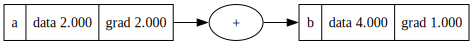

In [185]:
a = Value(2, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)

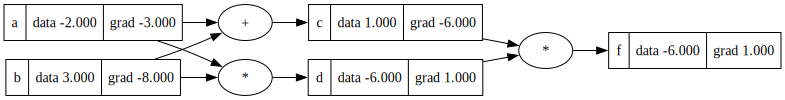

In [186]:
a = Value(-2, label='a')
b = Value(3, label='b')

c = a +b; c.label= 'c'
d= a * b; d.label='d'

f = d * c; f.label='f'

f.backward()
draw_dot(f)

## w/PyTorch

In [19]:
import torch

In [31]:
#inputs
x1 = torch.Tensor([2.0]).double() ;x1.requires_grad = True #becasue by default it thinks its a leaf node
x2 = torch.Tensor([0.0]).double() ;x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ;w1.requires_grad = True
w2 = torch.Tensor([-1.0]).double() ;w2.requires_grad = True
# bias
b = torch.Tensor([6.881373]).double() ;b.requires_grad = True

# n = ws + b
n = w1*x1 + w2*x2 + b
# tanh classifier
o = torch.tanh(n)

print(o.data.item())
o.backward()


print("---TORCH-----")
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071064519863152
---TORCH-----
x1 -1.500001396677975
w1 1.00000093111865
x2 -0.500000465559325
w2 0.0


In [32]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [33]:
o.item()

0.7071064519863152

## building Neuron


In [45]:
class Neuron:
    def __init__(self, nin): #number of neurons
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # n = wx + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
        out = act.tanh()
        return out


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] #a layer is a list of neurons and how many neurons (nout)

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts #intire neurons in a single layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #i + i+i current layer and the next one 

    def __call__(self, x): #call layers sequentially
        for layer in self.layers:
            x = layer(x)
        return x
        
        
x = [2.0,3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)       

Value(data=-0.8727681409105812, grad=0)

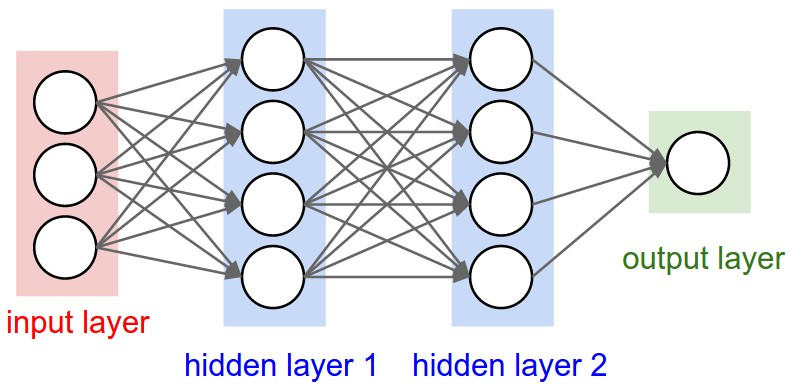

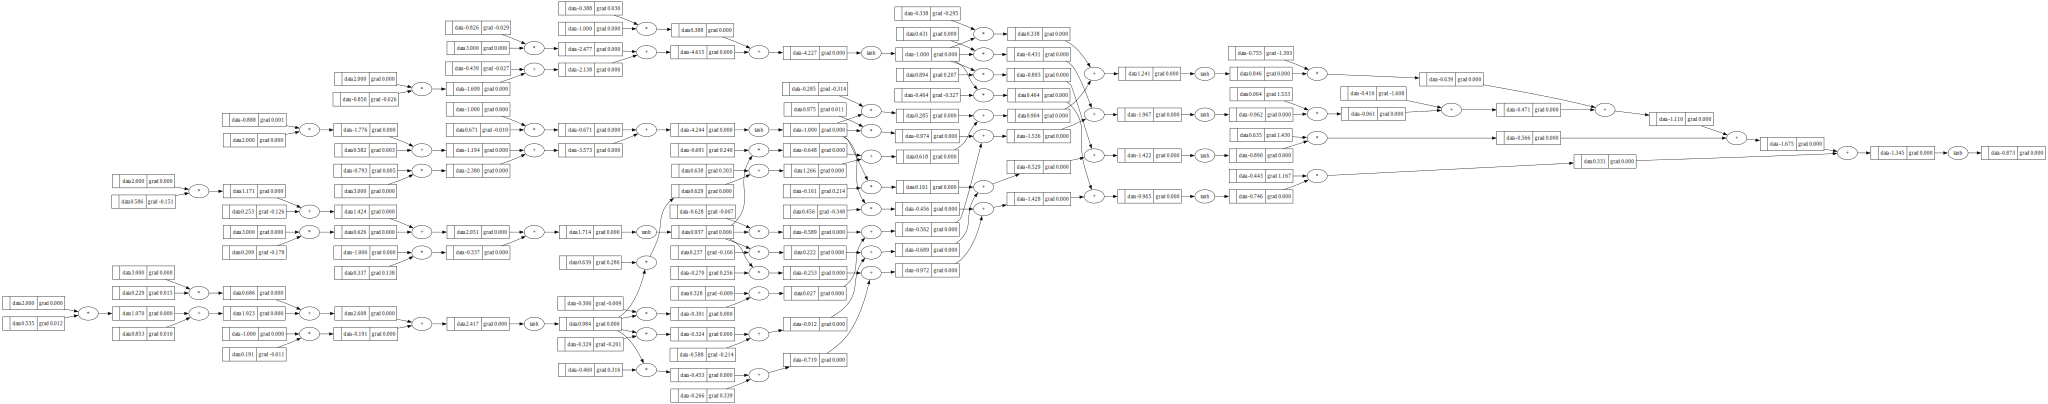

In [64]:
draw_dot(n(x))

## tiny dataset

In [162]:
#xs = np.random.randint(-2,4, size=(4,3))

In [68]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired output
ypred = [n(x) for x in xs]
ypred #output nn onthat xs 

[Value(data=-0.8727681409105812, grad=0),
 Value(data=-0.8727959542296287, grad=0),
 Value(data=-0.8904050446989319, grad=0),
 Value(data=-0.8843143927282926, grad=0)]

In [70]:
#how we gotta tune the weights to acheive the desired output; to better predict the desired
#trick for nn is a single number that measures how the network is doing
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=7.086093163740463, grad=0)

In [71]:
loss.backward()

In [76]:
n.layers[1].neurons[0].w[0].grad #negative influence on loss so slightly increasing the w for this particular neuron makes the loss to go down!

-0.017515446138381092

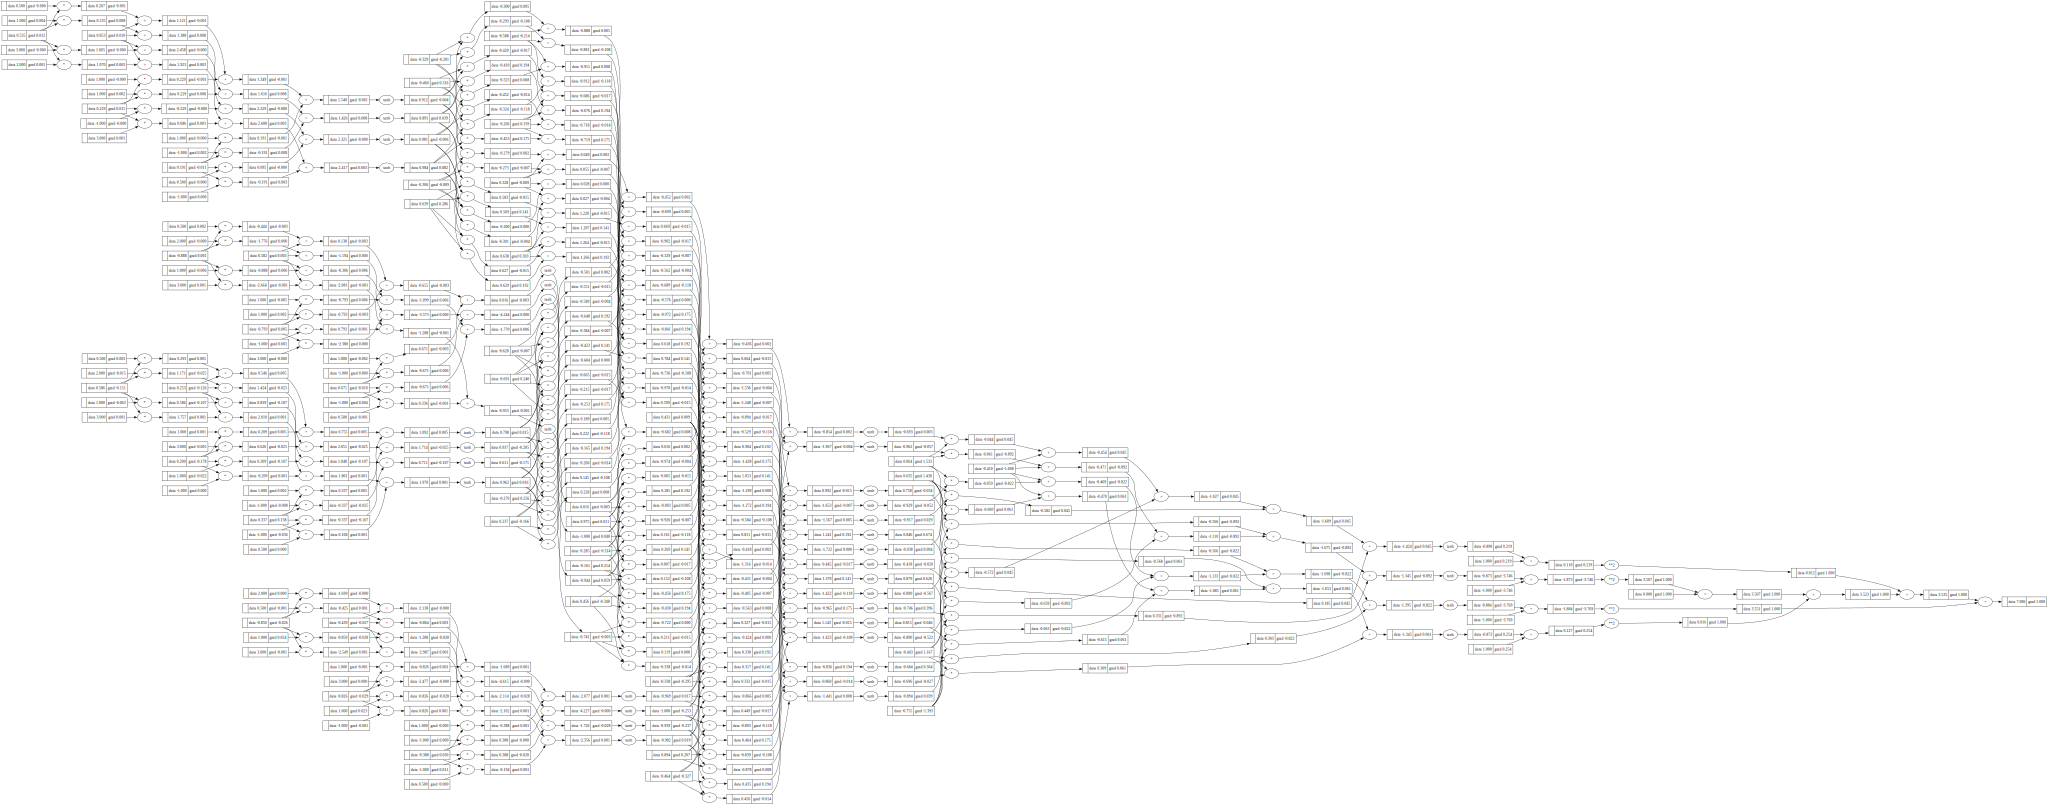

In [66]:
draw_dot(loss)